In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Linear models
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
# Decision Tree and Ensemble Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# Gradient Boosting Models for Regression (GBM's)
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
# Generalized Linear Models (GLM's)
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [4]:
# Load the dataset
df = pd.read_csv("graana_data.csv")

In [5]:
# check the dataset 
df.sample(5)

,Address,Price,Bathrooms,Bedrooms,Area,Property Type
83,"Bahria Town Phase 8, Rawalpindi",2.9 Crore,5,5,7 marla,residential
70,"DHA Homes, Islamabad",1.64 Crore,3,3,8 marla,residential
609,"Bahria Enclave, Islamabad",4 Crore,4,4,8 marla,residential
403,"Adyala Road, Rawalpindi",85 Lac,2,2,5 marla,residential
980,"DHA Phase 2, Lahore",6.7 Crore,5,5,1 kanal,residential


In [6]:
# check if the dataset has any missing values
df.isnull().sum()

Address          0
Price            0
Bathrooms        0
Bedrooms         0
Area             0
Property Type    0
dtype: int64

In [7]:
# check if the dataset has any duplicated values
df.duplicated().sum()

np.int64(180)

In [8]:
# check the shape of the dataset 
df.shape

(985, 6)

In [9]:
# drop the duplicated rows
df.drop_duplicates(inplace=True)

In [10]:
# check the shape after dropping duplicates
df.shape

(805, 6)

In [11]:
# check the basic info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 0 to 984
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Address        805 non-null    object
 1   Price          805 non-null    object
 2   Bathrooms      805 non-null    object
 3   Bedrooms       805 non-null    object
 4   Area           805 non-null    object
 5   Property Type  805 non-null    object
dtypes: object(6)
memory usage: 44.0+ KB


# Exploratory Data Analysis

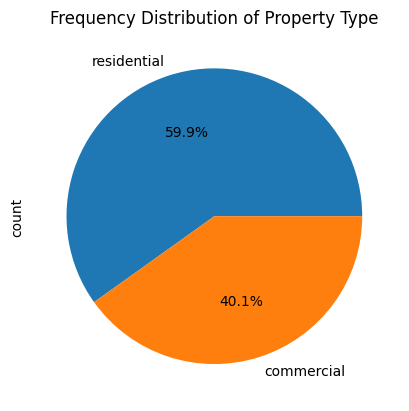

In [12]:
# Check the distribution of the property type
df["Property Type"].value_counts().plot(kind="pie", autopct="%1.1f%%")

plt.title("Frequency Distribution of Property Type")
plt.show()

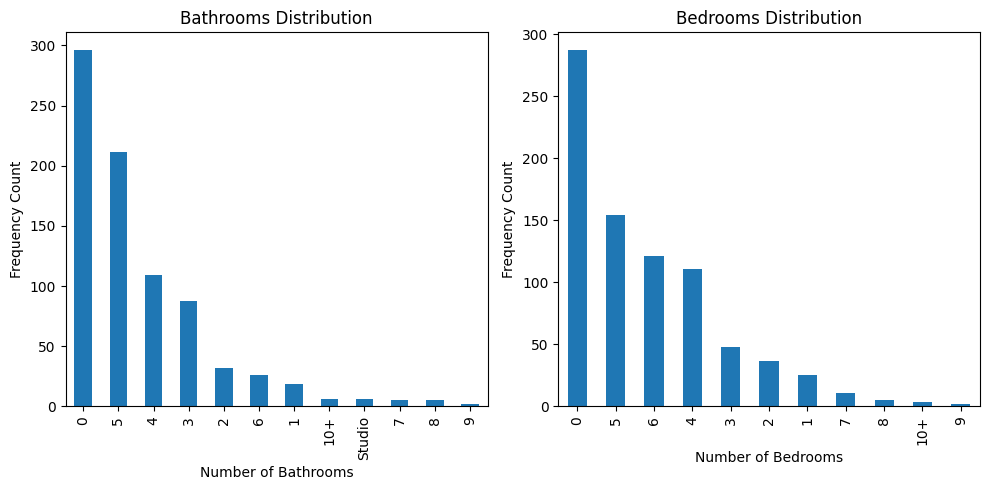

In [13]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 rows, 2 column

# Creating a bar chart for bathrooms
df["Bathrooms"].value_counts().plot(kind="bar", ax=axs[0])
axs[0].set_xlabel("Number of Bathrooms")
axs[0].set_ylabel("Frequency Count")
axs[0].set_title("Bathrooms Distribution")

# Creating a bar chart for bedrooms
df["Bedrooms"].value_counts().plot(kind="bar", ax=axs[1])
axs[1].set_xlabel("Number of Bedrooms")
axs[1].set_ylabel("Frequency Count")
axs[1].set_title("Bedrooms Distribution")

# Adjust layout
plt.tight_layout()
plt.show()

- An Unknown category "Studio" and "10+".

# Feature Engineering

In [14]:
df["city"] = df["Address"].str.split().str[-1]

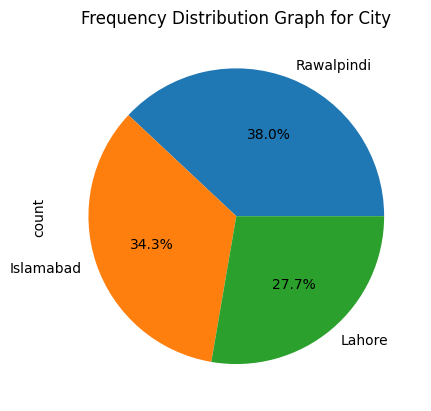

In [15]:
# Check the distribution of cities via pie chart
df["city"].value_counts().plot(kind="pie" ,autopct="%1.1f%%")

plt.title("Frequency Distribution Graph for City")
plt.show()

<Axes: xlabel='Price'>

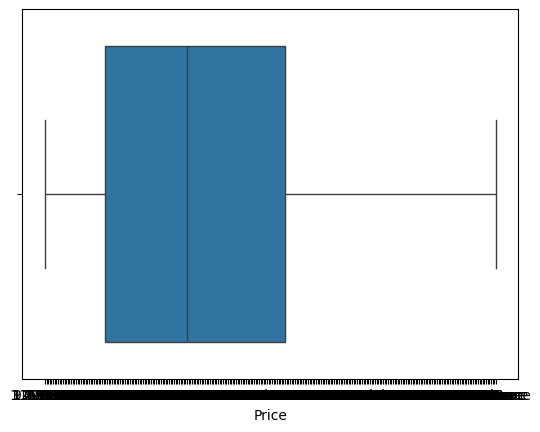

In [16]:
# check the outliers in price column
sns.boxplot(data=df, x="Price")

<Axes: ylabel='Area'>

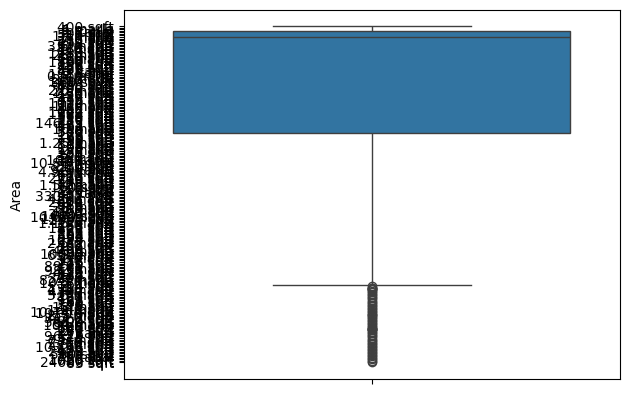

In [17]:
sns.boxplot(df["Area"])

In [18]:
# now converting the price column into single unit crore 

# check all units present in price column
df["Price"].str.split().str[1].value_counts()

Price
Crore    616
Lac      175
Arab       4
Name: count, dtype: int64

- Three units are available

In [19]:
def price_conversion(price_column):
    """
    Convert a price column from lakhs or arabs to crores.

    Parameters:
    price_column (pd.Series): A pandas Series with prices as strings, e.g., '50 Lac', '1.2 Arab'.

    Returns:
    pd.Series: A pandas Series with prices converted to crores.
    """
    # Split the price column into value and unit
    price_split = price_column.str.split()
    value = price_split.str[0].astype(float)
    unit = price_split.str[1].str.lower()

    # Convert values based on unit
    value_converted = value.where(unit != "lac", value / 100)
    value_converted = value_converted.where(unit != "lakh", value_converted / 100)
    value_converted = value_converted.where(unit != "arab", value_converted * 100)
    
    return value_converted

In [20]:
# applying this function on our price column now

df['Price'] = price_conversion(df['Price'])

In [21]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Property Type,city
0,"Bahria Town - Sector F, Lahore",1.60,0,0,400 sqft,commercial,Lahore
1,"Bahria Enclave, Sector A, Islamabad",11.10,10+,6,4 marla,commercial,Islamabad
2,"Bahria Town - Sector E , Lahore",1.95,4,4,5 marla,residential,Lahore
3,"DHA Phase 2, Islamabad",9.75,5,5,1 kanal,residential,Islamabad
4,"Bahria Town - Sector E , Lahore",0.65,1,1,395 sqft,residential,Lahore


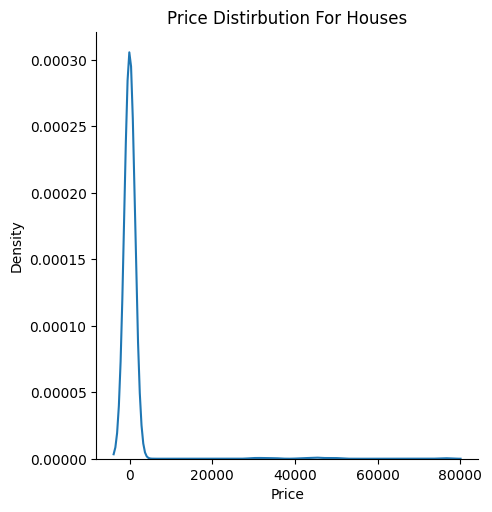

In [22]:
# Checking the distribution of Price column
sns.displot(data=df, x="Price", kind="kde")

plt.title("Price Distirbution For Houses")
plt.show()

- Price column is highly skewed (right skewed)

In [23]:
# Now convert the area column into single unit marla
# 1 kanal = 20 marla
# 1 sqyd (square yard) = 0.01 Marla
# 1 sqrt (square feet) = 0.0025 Marla

# First check the available units for area column
df["Area"].str.split().str[1].value_counts()

Area
marla    469
sqft     262
kanal     70
sqyd       4
Name: count, dtype: int64

In [24]:
def convert_to_marla(area_series):
    """
    Convert a Pandas Series of area values with units to marla.

    Parameters:
    area_series (pd.Series): A pandas Series with area values as strings, e.g., '500 Sqyd', '2 Kanal'.

    Returns:
    pd.Series: A pandas Series with area values converted to marla.
    """
    # Split the area series into value and unit
    area_split = area_series.str.split()
    value = area_split.str[0].astype(float)
    unit = area_split.str[1].str.lower()

    # Conversion dictionary
    conversion_factors = {
        'kanal': 20,
        'marla': 1,
        'sqyd': 0.03,  # Correct conversion factor
        'sqft': 0.0033  # Correct conversion factor
    }

    # Convert values based on the unit
    value_converted = value * unit.map(conversion_factors)

    # Handle units not in conversion_factors
    if value_converted.isna().any():
        raise ValueError(f"Unknown unit found in area_series: {area_series[value_converted.isna()].unique()}")

    return value_converted

In [25]:
# Apply the conversion function to the Area column
df['Area'] = convert_to_marla(df['Area'])

In [26]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Property Type,city
0,"Bahria Town - Sector F, Lahore",1.60,0,0,1.3200,commercial,Lahore
1,"Bahria Enclave, Sector A, Islamabad",11.10,10+,6,4.0000,commercial,Islamabad
2,"Bahria Town - Sector E , Lahore",1.95,4,4,5.0000,residential,Lahore
3,"DHA Phase 2, Islamabad",9.75,5,5,20.0000,residential,Islamabad
4,"Bahria Town - Sector E , Lahore",0.65,1,1,1.3035,residential,Lahore


In [27]:
df["Bedrooms"].value_counts()

Bedrooms
0      287
5      154
6      121
4      111
3       48
2       37
1       25
7       11
8        5
10+      4
9        2
Name: count, dtype: int64

In [28]:
# replacing the 10+ with 10 for analysis and making it a numerical column
df["Bedrooms"] = df["Bedrooms"].replace("10+",10).astype(int)

In [29]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Property Type,city
0,"Bahria Town - Sector F, Lahore",1.60,0,0,1.3200,commercial,Lahore
1,"Bahria Enclave, Sector A, Islamabad",11.10,10+,6,4.0000,commercial,Islamabad
2,"Bahria Town - Sector E , Lahore",1.95,4,4,5.0000,residential,Lahore
3,"DHA Phase 2, Islamabad",9.75,5,5,20.0000,residential,Islamabad
4,"Bahria Town - Sector E , Lahore",0.65,1,1,1.3035,residential,Lahore


In [30]:
df["Bathrooms"].value_counts()

Bathrooms
0         296
5         211
4         109
3          88
2          32
6          26
1          19
10+         6
Studio      6
7           5
8           5
9           2
Name: count, dtype: int64

In [31]:
# Convert the Studio into nan 
df['Bathrooms'] = df['Bathrooms'].replace('Studio', np.nan)

# Drop rows where 'Bathrooms' is NaN
df.dropna(subset=['Bathrooms'],inplace=True)

# Convert the 10+ into 10 in bathrooms
df["Bathrooms"] = df["Bathrooms"].replace("10+",10).astype(int)

In [32]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Property Type,city
0,"Bahria Town - Sector F, Lahore",1.60,0,0,1.3200,commercial,Lahore
1,"Bahria Enclave, Sector A, Islamabad",11.10,10,6,4.0000,commercial,Islamabad
2,"Bahria Town - Sector E , Lahore",1.95,4,4,5.0000,residential,Lahore
3,"DHA Phase 2, Islamabad",9.75,5,5,20.0000,residential,Islamabad
4,"Bahria Town - Sector E , Lahore",0.65,1,1,1.3035,residential,Lahore


In [33]:
df["Price"].max()

np.float64(76230.0)

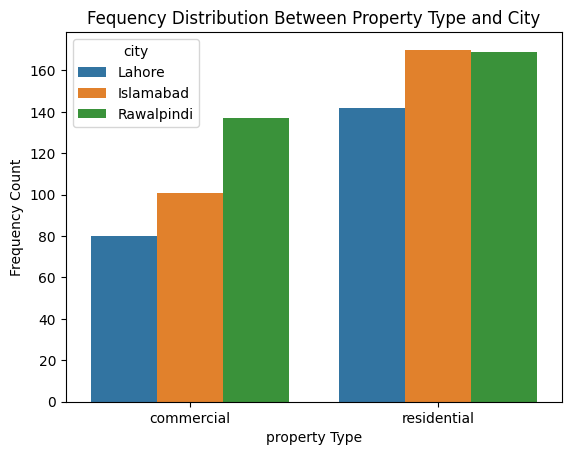

In [34]:
# check the distribution between property type and city
sns.countplot(data=df, x="Property Type", hue="city")

plt.xlabel("property Type")
plt.ylabel("Frequency Count")
plt.title("Fequency Distribution Between Property Type and City")
plt.show()

- It seems mostly people own residental property type.

<Axes: xlabel='city', ylabel='Price'>

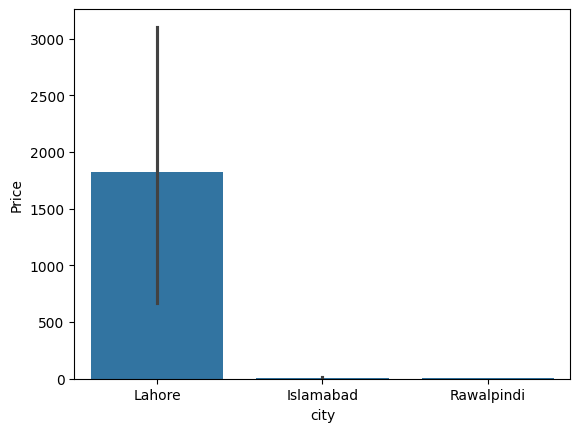

In [35]:
# lets check which city has more expensive houses
sns.barplot(data=df, x="city", y="Price")

<Axes: ylabel='Price'>

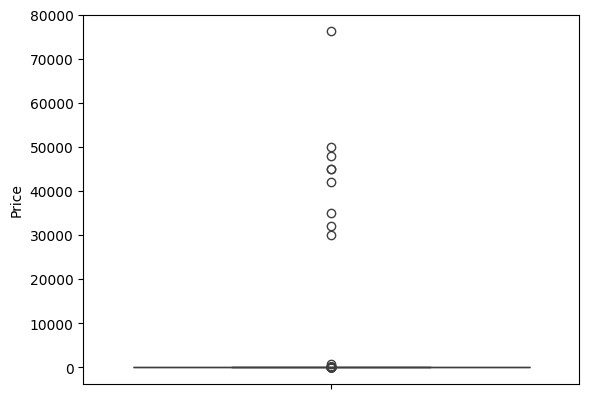

In [36]:
sns.boxplot(df["Price"])

In [37]:
def skewness_removal(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    This function removes skewness in the specified column by applying a log, square root,
    cube root, or Box-Cox transformation if the skewness is greater than 0.5.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be transformed.
    column (str): The name of the column to transform.

    Returns:
    pd.DataFrame: The DataFrame with the transformed column.
    """
    skewness = df[column].skew()
    print(f"The column '{column}' has a skewness of {skewness}")

    if skewness > 0.5:
        # Check for negative values
        if (df[column] <= 0).any():
            raise ValueError(f"Column '{column}' contains non-positive values, cannot apply log transformation.")

        # Applying log transform
        df[column] = np.log1p(df[column])
        skewness = df[column].skew()
        print(f"The skewness after log transformation is {skewness}")

        # If skewness is still high, apply further transformations
        if skewness > 0.5:
            df[column] = np.sqrt(df[column])
            skewness = df[column].skew()
            print(f"The skewness after square root transformation is {skewness}")

            if skewness > 0.5:
                df[column] = np.cbrt(df[column])
                skewness = df[column].skew()
                print(f"The skewness after cube root transformation is {skewness}")

                if skewness > 0.5:
                    # Box-Cox transformation (requires positive values)
                    df[column], _ = boxcox(df[column] + 1)  # adding 1 to ensure all values are positive
                    skewness = df[column].skew()
                    print(f"The skewness after Box-Cox transformation is {skewness}")
    else:
        print(f"No transformation applied to '{column}' as skewness is not greater than 0.5")

    return df

In [38]:
df = skewness_removal(df, "Price")

The column 'Price' has a skewness of 10.586244306029043
The skewness after log transformation is 4.479444426583924
The skewness after square root transformation is 1.576998806781667
The skewness after cube root transformation is 0.06300764845587344


In [39]:
df["Price"].skew()

np.float64(0.06300764845587344)

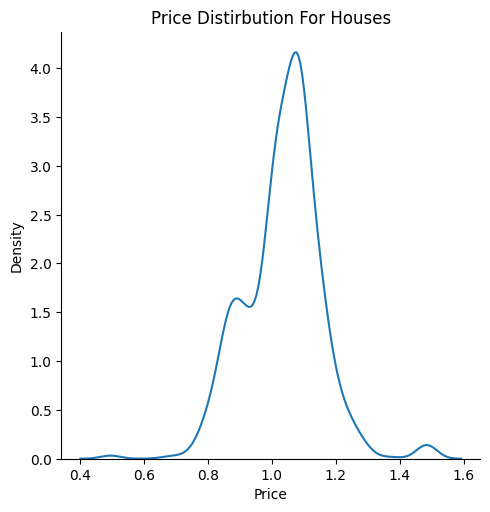

In [40]:
# Checking the distribution of Price column after skewness removal
sns.displot(data=df, x="Price", kind="kde")

plt.title("Price Distirbution For Houses")
plt.show()

<Axes: xlabel='city', ylabel='Price'>

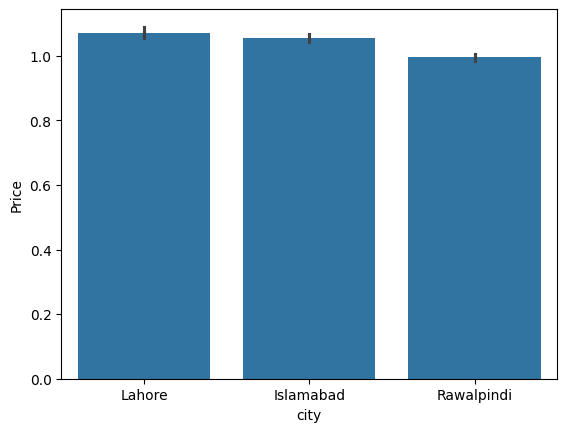

In [41]:
# lets check which city has more expensive houses (after skewness removal)
sns.barplot(data=df, x="city", y="Price")

- Rawalpindi has the least expensive houses whereas lahore has the most expensive houses.

<Axes: ylabel='Price'>

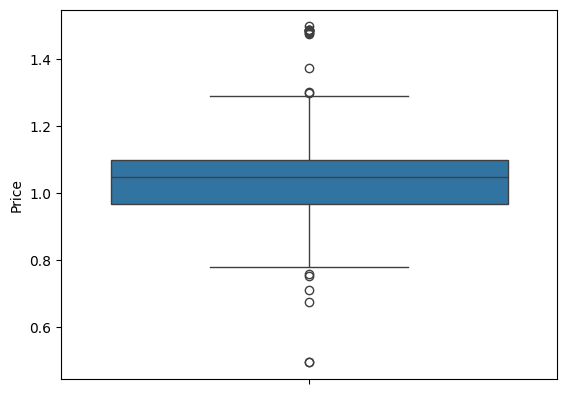

In [42]:
# lets check if there are still outliers in the dataset.
sns.boxplot(df["Price"])

In [43]:
def cap_outliers(df: pd.DataFrame, column: str, threshold: float = 3) -> pd.DataFrame:
    """
    Caps the outliers in the specified column of the DataFrame using a threshold.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be capped.
    column (str): The name of the column to cap.
    threshold (float): The number of standard deviations from the mean to use as limits.

    Returns:
    pd.DataFrame: The DataFrame with capped values in the specified column.
    """
    mean = df[column].mean()
    std = df[column].std()

    upper_limit = mean + threshold * std
    lower_limit = mean - threshold * std

    df[column] = np.where(
        df[column] > upper_limit,
        upper_limit,
        np.where(
            df[column] < lower_limit,
            lower_limit,
            df[column]
        )
    )

    return df

In [44]:
df = cap_outliers(df, "Price")

<Axes: ylabel='Price'>

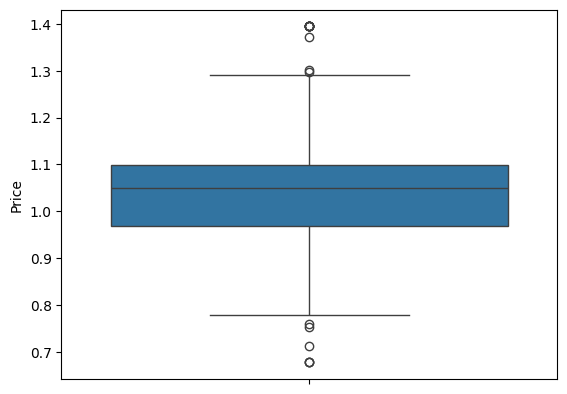

In [45]:
sns.boxplot(df["Price"])

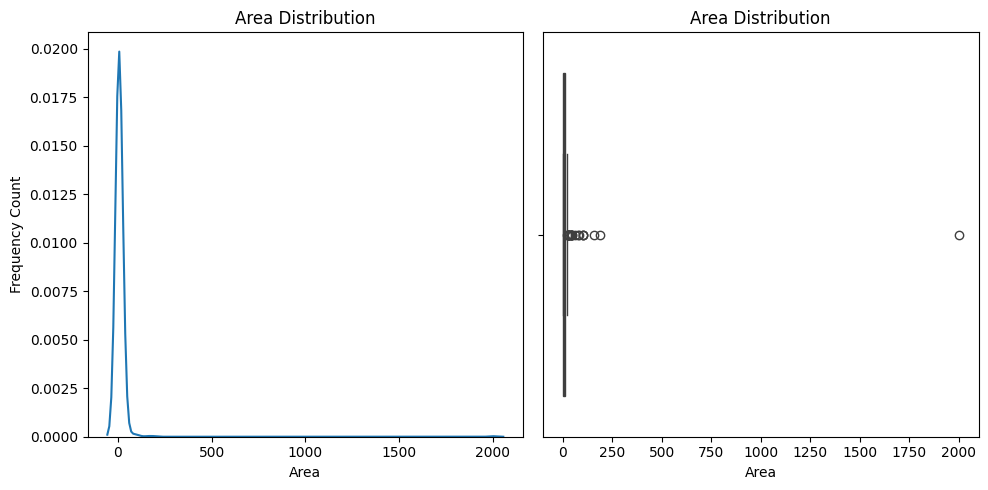

In [46]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Creating a histogram for Area
sns.kdeplot(data=df, x="Area", ax=axs[0])
axs[0].set_ylabel("Frequency Count")
axs[0].set_title("Area Distribution")

# Creating a box plot for Area
sns.boxplot(data=df, x="Area", ax=axs[1])
axs[1].set_title("Area Distribution")

# Adjust layout
plt.tight_layout()
plt.show()

In [47]:
df = cap_outliers(df=df, column="Area")

<Axes: ylabel='Area'>

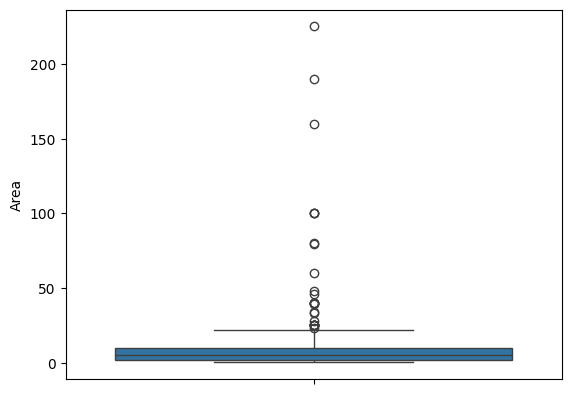

In [48]:
sns.boxplot(df["Area"])

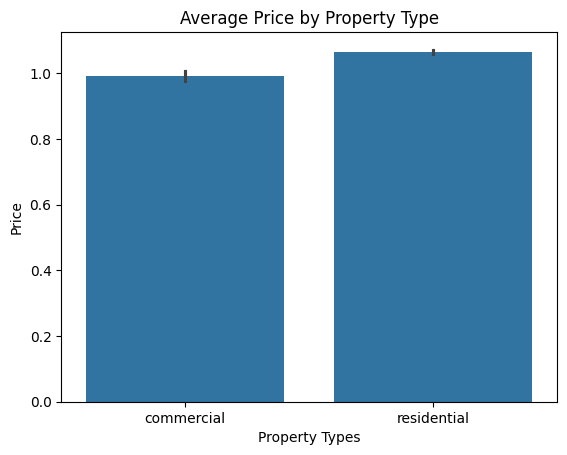

In [49]:
# Lets check which property type is expensive
sns.barplot(data=df, x="Property Type", y="Price")

plt.xlabel("Property Types")
plt.ylabel("Price")
plt.title("Average Price by Property Type")
plt.show()

- Residental Poperty Type is more expensive

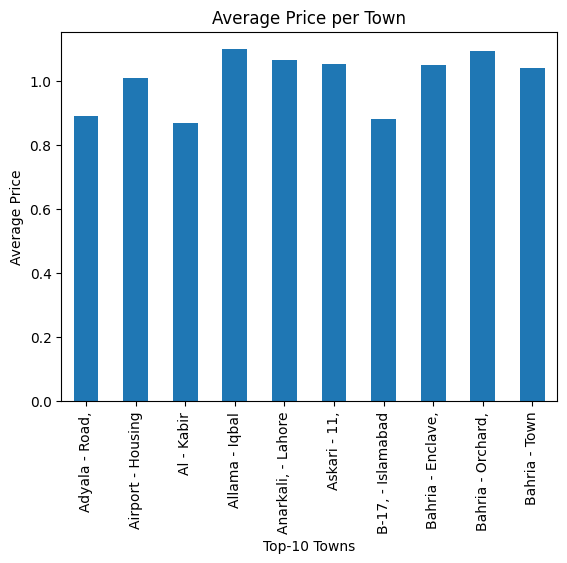

In [50]:
# Extract the first two words from 'Address' to create a 'Town' column
df["Town"] = df["Address"].str.split().str[:2].str.join(' - ')

# Calculate the average price by town and plot the top 10 towns
df.groupby('Town')['Price'].mean().head(10).plot(kind="bar")

plt.xlabel("Top-10 Towns")
plt.ylabel("Average Price")
plt.title("Average Price per Town")
plt.show()

- Top 3 expensive towns are from Lahore.

In [51]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Property Type,city,Town
0,"Bahria Town - Sector F, Lahore",0.992444,0,0,1.3200,commercial,Lahore,Bahria - Town
1,"Bahria Enclave, Sector A, Islamabad",1.164465,10,6,4.0000,commercial,Islamabad,"Bahria - Enclave,"
2,"Bahria Town - Sector E , Lahore",1.013191,4,4,5.0000,residential,Lahore,Bahria - Town
3,"DHA Phase 2, Islamabad",1.155068,5,5,20.0000,residential,Islamabad,DHA - Phase
4,"Bahria Town - Sector E , Lahore",0.891129,1,1,1.3035,residential,Lahore,Bahria - Town


In [52]:
df["Town"].nunique()

136

In [53]:
# as the town column has 133 cats we will do Target encoding efficient way for regression tasks to handle high cardinalty

# Calculate mean price for each town
mean_price = df.groupby('Town')['Price'].mean()

# Map the mean price back to the DataFrame
df['Town'] = df['Town'].map(mean_price)

In [54]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Property Type,city,Town
0,"Bahria Town - Sector F, Lahore",0.992444,0,0,1.3200,commercial,Lahore,1.039389
1,"Bahria Enclave, Sector A, Islamabad",1.164465,10,6,4.0000,commercial,Islamabad,1.050734
2,"Bahria Town - Sector E , Lahore",1.013191,4,4,5.0000,residential,Lahore,1.039389
3,"DHA Phase 2, Islamabad",1.155068,5,5,20.0000,residential,Islamabad,1.094369
4,"Bahria Town - Sector E , Lahore",0.891129,1,1,1.3035,residential,Lahore,1.039389


In [55]:
def binary_encoding(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply OneHotEncoding to specified columns in the DataFrame.

    Parameters:
    columns (list): List of column names to encode.
    df (pd.DataFrame): The DataFrame containing the columns.

    Returns:
    pd.DataFrame: The DataFrame with encoded columns.
    """
    ohe = OneHotEncoder(sparse_output=False)

    for column in columns:
        # Fit and transform the column
        encoded_cols = ohe.fit_transform(df[[column]])
        # Create a DataFrame with the encoded columns, ensuring the index matches the original DataFrame
        encoded_df = pd.DataFrame(encoded_cols, columns=ohe.get_feature_names_out([column]), index=df.index)
        # Concatenate the encoded columns to the original DataFrame
        df = pd.concat([df, encoded_df], axis=1)
        # Drop the original column
        df.drop(column, axis=1, inplace=True)
    
    return df

df = binary_encoding(columns=["Property Type", "city"], df=df)

In [56]:
df.head()

,Address,Price,Bathrooms,Bedrooms,Area,Town,Property Type_commercial,Property Type_residential,city_Islamabad,city_Lahore,city_Rawalpindi
0,"Bahria Town - Sector F, Lahore",0.992444,0,0,1.3200,1.039389,1.0,0.0,0.0,1.0,0.0
1,"Bahria Enclave, Sector A, Islamabad",1.164465,10,6,4.0000,1.050734,1.0,0.0,1.0,0.0,0.0
2,"Bahria Town - Sector E , Lahore",1.013191,4,4,5.0000,1.039389,0.0,1.0,0.0,1.0,0.0
3,"DHA Phase 2, Islamabad",1.155068,5,5,20.0000,1.094369,0.0,1.0,1.0,0.0,0.0
4,"Bahria Town - Sector E , Lahore",0.891129,1,1,1.3035,1.039389,0.0,1.0,0.0,1.0,0.0


In [57]:
# Split the data into features and target
x = df.drop(columns=["Address", "Price"], axis=1)
y = df["Price"]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [59]:
# standardzing the dataset

std = StandardScaler()

x_train_scaled = std.fit_transform(x_train)
x_test_scaled = std.transform(x_test)

In [60]:
# Lets check which model works best on default parameters
# List of regression models
regression_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(random_state=0),
    GradientBoostingRegressor(random_state=0),
    XGBRegressor(random_state=0),
    LGBMRegressor(random_state=0)
]

def compare_regression_models_cross_validation(X, Y):
    for model in regression_models:
        cv_score = cross_val_score(model, X, Y, cv=5)
        mean_score = cv_score.mean()
        mean_score = round(mean_score * 100, 2)

        print(f'Cross Validation scores for {model.__class__.__name__}: {cv_score}')
        print(f'Mean Accuracy score for {model.__class__.__name__}: {mean_score}%')
        print('---------------------------------------------------------------')


In [61]:
compare_regression_models_cross_validation(x_train_scaled, y_train)

Cross Validation scores for LinearRegression: [0.52308839 0.61883097 0.4571441  0.69815942 0.61135388]
Mean Accuracy score for LinearRegression: 58.17%
---------------------------------------------------------------
Cross Validation scores for Ridge: [0.52345631 0.62801193 0.45718732 0.69833524 0.61135297]
Mean Accuracy score for Ridge: 58.37%
---------------------------------------------------------------
Cross Validation scores for Lasso: [-0.0079978  -0.0044391  -0.00679075 -0.00973594 -0.02511745]
Mean Accuracy score for Lasso: -1.08%
---------------------------------------------------------------
Cross Validation scores for ElasticNet: [-0.0079978  -0.0044391  -0.00679075 -0.00973594 -0.02511745]
Mean Accuracy score for ElasticNet: -1.08%
---------------------------------------------------------------
Cross Validation scores for DecisionTreeRegressor: [0.72740314 0.58745545 0.55156515 0.43667087 0.43862144]
Mean Accuracy score for DecisionTreeRegressor: 54.83%
--------------------

- On default parameter's GradientBosstingRegressor gives the highest accuracy

In [62]:
# Define the parameter grid (Hyperparameter Tuning)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the model
gbr = GradientBoostingRegressor()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(x_train_scaled, y_train)

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.7183505602672643


In [63]:

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)

    return rmse, mae, r2

In [64]:
predicted_value = grid_search.predict(x_test_scaled)

In [65]:

(rmse, mae, r2) = eval_metrics(y_test, predicted_value)


print("rmse = ", rmse)
print("mae = ", mae)
print("r2 = ", r2)

rmse =  0.0636943553693991
mae =  0.03655748805142918
r2 =  0.6748335132094991


In [66]:
# model is done